# Knowledge graph experiment data generation

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

In [3]:
# randomly generate a graph

# graph parameters
radiuses = [0.2]* n_relations
dims = [2] * n_relations # 2 for now to make it easy to visualize

# generate graph for each relation
# i'm using random geometric graph for now
# roughly, my thinking is that this may correspond to some more "interesting" type of relation which encodes a transitivity property
# we can think about generating this in different ways later
graphs = [nx.random_geometric_graph(n=node_vocab, radius=radiuses[i], dim=dims[i], p=2) for i in range(n_relations)]

# we transform to a DAG

def to_directed(graph):
    graph = graph.to_directed()

    def violate_direction(edge):
        a = int(edge[0][1:])
        b = int(edge[1][1:])
        return a >= b
    edges_to_remove = [edge for edge in graph.edges if violate_direction(edge)]

    graph.remove_edges_from(edges_to_remove )

    return graph

graphs = [to_directed(graph) for graph in graphs]


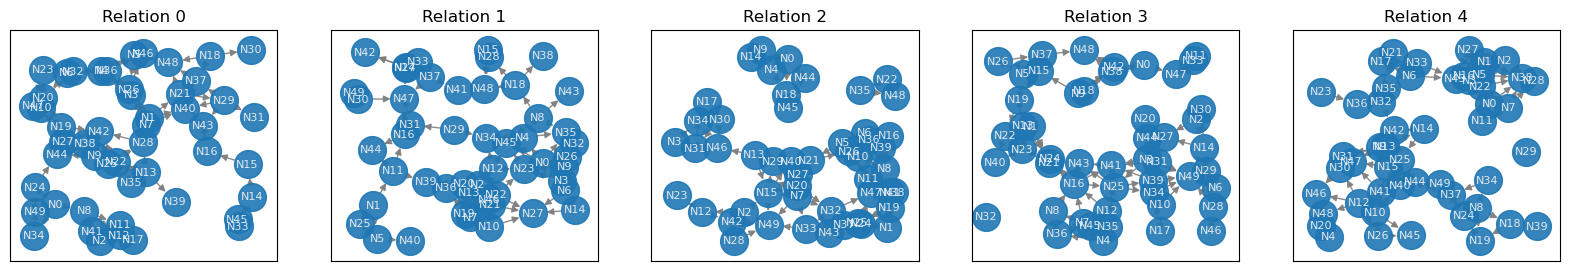

In [4]:
rel = 0

# visualize graphs
fig, axs = plt.subplots(ncols=n_relations, figsize=(4*n_relations,3))
options = {"edge_color": "tab:gray", "node_size": 400, "alpha": 0.9, "node_color": "tab:blue", "font_color": "whitesmoke", "font_size": 8}
for rel in range(n_relations):
    pos = nx.get_node_attributes(graphs[rel], 'pos')
    nx.draw_networkx(graphs[rel], pos=pos, **options, ax=axs[rel])
    axs[rel].set_title(f"Relation {rel}");

In [5]:
facts = {rel: list(graphs[rel].edges) for rel in range(n_relations)}

In [6]:
def sample_fact(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)
    # sample fact
    fact_idx = np.random.choice(len(facts[rel]))
    fact = facts[rel][fact_idx]
    n1, n2 = fact
    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]

def sample_falsehood(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)

    while True:
        # sample falsehood
        n1, n2 = np.random.choice(node_vocab, size=2)
        if (n1, n2) not in facts[rel]:
            break

    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]


In [7]:
# generate context of true but irrelevant facts
def generate_robustness_example(context_length, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_fact(return_idx=return_idx)

    for i in range(context_length):
        # NOTE: for now, not checking if irrelevant; sampling randomly so most likely irrelevant
        ctx_fact = sample_fact(return_idx=return_idx)
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [8]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_robustness_example(3, return_idx=False))

<CTX> N16 R2 N36 <SEP> N22 R3 N23 <SEP> N1 R4 N3 <SEP> </CTX> <QUERY> N14 R3 N27 </QUERY> <EOS>
<CTX> N7 R2 N33 <SEP> N11 R2 N26 <SEP> N38 R3 N42 <SEP> </CTX> <QUERY> N14 R0 N33 </QUERY> <EOS>
<CTX> N27 R2 N29 <SEP> N11 R0 N12 <SEP> N20 R2 N29 <SEP> </CTX> <QUERY> N21 R0 N29 </QUERY> <EOS>
<CTX> N21 R2 N26 <SEP> N13 R0 N28 <SEP> N13 R1 N19 <SEP> </CTX> <QUERY> N27 R3 N44 </QUERY> <EOS>
<CTX> N33 R3 N47 <SEP> N7 R1 N46 <SEP> N25 R4 N40 <SEP> </CTX> <QUERY> N22 R2 N35 </QUERY> <EOS>


In [9]:
# query is inconsistent with world knowledge
def generate_controllability_example(context_length, insert_pos=None, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_falsehood(return_idx=return_idx)

    contexts = []
    for i in range(context_length-1):
        ctx_fact = sample_fact(return_idx=return_idx)
        contexts.append(ctx_fact)

    # insert query fact at random position of context to test controllability
    if insert_pos is None:
        insert_pos = np.random.randint(context_length)
    contexts.insert(insert_pos, query_fact)

    for ctx_fact in contexts:
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [10]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_controllability_example(3, return_idx=False))

<CTX> N41 R4 N47 <SEP> N4 R3 N12 <SEP> N48 R2 N7 <SEP> </CTX> <QUERY> N48 R2 N7 </QUERY> <EOS>
<CTX> N7 R4 N11 <SEP> N40 R2 N43 <SEP> N23 R0 N47 <SEP> </CTX> <QUERY> N40 R2 N43 </QUERY> <EOS>
<CTX> N7 R2 N21 <SEP> N16 R4 N43 <SEP> N10 R3 N30 <SEP> </CTX> <QUERY> N10 R3 N30 </QUERY> <EOS>
<CTX> N19 R1 N20 <SEP> N27 R4 N43 <SEP> N3 R3 N42 <SEP> </CTX> <QUERY> N3 R3 N42 </QUERY> <EOS>
<CTX> N21 R0 N37 <SEP> N10 R3 N39 <SEP> N46 R1 N31 <SEP> </CTX> <QUERY> N46 R1 N31 </QUERY> <EOS>


In [11]:
# print some examples of robustness examples (print token idx)
for _ in range(5):
    print(generate_controllability_example(3, return_idx=True))

[55, 20, 52, 32, 57, 39, 54, 34, 57, 15, 54, 42, 57, 56, 58, 39, 54, 34, 59, 60]
[55, 21, 54, 35, 57, 17, 50, 37, 57, 17, 51, 37, 57, 56, 58, 17, 50, 37, 59, 60]
[55, 30, 54, 47, 57, 12, 51, 12, 57, 24, 52, 37, 57, 56, 58, 12, 51, 12, 59, 60]
[55, 15, 52, 29, 57, 1, 52, 19, 57, 7, 52, 1, 57, 56, 58, 7, 52, 1, 59, 60]
[55, 31, 53, 49, 57, 35, 52, 35, 57, 0, 54, 11, 57, 56, 58, 35, 52, 35, 59, 60]


In [12]:
# pre-training: "robustness" context_length=0

# training
# w.p. 1/3
# just facts: "robustness" with context_length=0
# w.p. 1/3
# robustness: uniformly context_length=1,2,3
# w.p. 1/3
# controllability: uniformly context_length=1,2,3

# validation
# same but separate context_lengths to different datasets to compute separate metrics